# Phase 1 : Basic Model


**Context :** Simple recreation of the model specified in the `sujet du projet`


### Mathematical Model
The speed $v_n$ of the $n$-th car depends on the distance $\alpha_n$ between the $n$ -th and $n+1$ -th cars.
$$ v_n = V \cdot F(\alpha_n) $$

$$
F(\alpha) =
\begin{cases}
1 - \exp\left(-\frac{\alpha - \alpha_c}{\alpha_v - \alpha_c}\right) & \text{si } \alpha > \alpha_c \\
0 & \text{si } \alpha \le \alpha_c
\end{cases}
$$

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

### Parametres du modele

In [2]:
# Paramètres des voitures

N = 50           # Nombre de véhicules
V_max = 30.0     # Vitesse maximale (m/s)
alpha_c = 10.0   # Distance critique 
alpha_v = 40.0   # Distance confortable
alpha_inf = 60.0 # Distance quand il y a pas de voitures devant

# Paramètres temporels
dt = 0.2         # Pas de temps (s)
T_total = 20.0   # Durée totale de la simulation (s)

### Helpers

In [3]:
def F(a):
    return (a > alpha_c) * (1 - np.exp(-(a - alpha_c) / (alpha_v - alpha_c)))

def alpha(x):
    res = np.roll(x, -1) - x
    res[-1] = alpha_inf
    return res

def vitesse(F, x):
    return V_max * F(alpha(x))

### Simulation

In [4]:
def simulate():
    """
    Exécute la simulation temporelle selon la méthode d'Euler explicite.
    """
    steps = int(T_total / dt)

    # indexed by the step and the vehicle index
    positions = np.zeros((steps, N))

    # 0 last, N first
    positions[0] = np.arange(N) * 5.0

    # Simulation loop
    for t in range(steps - 1):
        cur_x = positions[t] # Current x
        alphas = cur_x[1:] - cur_x[:-1]  # Distances
        v = V_max * F(alphas) # Speeds

        # Euler Explicit step : x = x + v * dt
        positions[t+1, :-1] = cur_x[:-1] + v * dt
        positions[t+1, -1] = cur_x[-1] + V_max * F(alpha_inf) * dt

    return positions

# Execution
res = simulate()
print(f"Simulation completed. Steps: {res.shape[0]}")

Simulation completed. Steps: 100


### Visualizations

In [5]:
## Plot properties
from matplotlib.colors import hsv_to_rgb

# Specifying a color for each car
hues = np.linspace(0, 0.7, N, endpoint=False) 
saturation = 0.8
value = 0.9

colors_hsv = np.stack([hues, np.full(N, saturation), np.full(N, value)], axis=1)
colors = hsv_to_rgb(colors_hsv)

In [6]:
#Plotting functions
def position_plot(sim, ax):
    # Plotting position/time 
    
    for ind, it in enumerate(sim):
        ax.scatter(it, ind*np.ones_like(it), c=colors)
    ax.set_xlabel("Position")
    ax.set_ylabel("Time")
    ax.set_title("Position - Time plot")
    


def speed_plot(sim, F, ax):
    t = np.arange(0, T_total, dt)
    vitesses = np.zeros_like(sim)
    for ind, l in enumerate(sim):
        vitesses[ind] = vitesse(F, l)/ V_max * F(alpha_inf)
    for i in range(N):
        ax.plot(t, vitesses[:, i], c=colors[i])
    
    ax.set_xlabel("Time")
    ax.set_ylabel("Speed")
    ax.set_title("Time - Speed plot")


def distance_plot(sim, ax):
    positions_finales = sim[-1]
    distances_finales = alpha(positions_finales)


    ax.scatter(positions_finales, np.zeros_like(positions_finales), marker="*", c = colors)
    ax.plot(positions_finales, distances_finales/alpha_inf)
    ax.set_xlabel("Time")
    ax.set_ylabel("Speed")
    ax.set_title("Positions et distances")

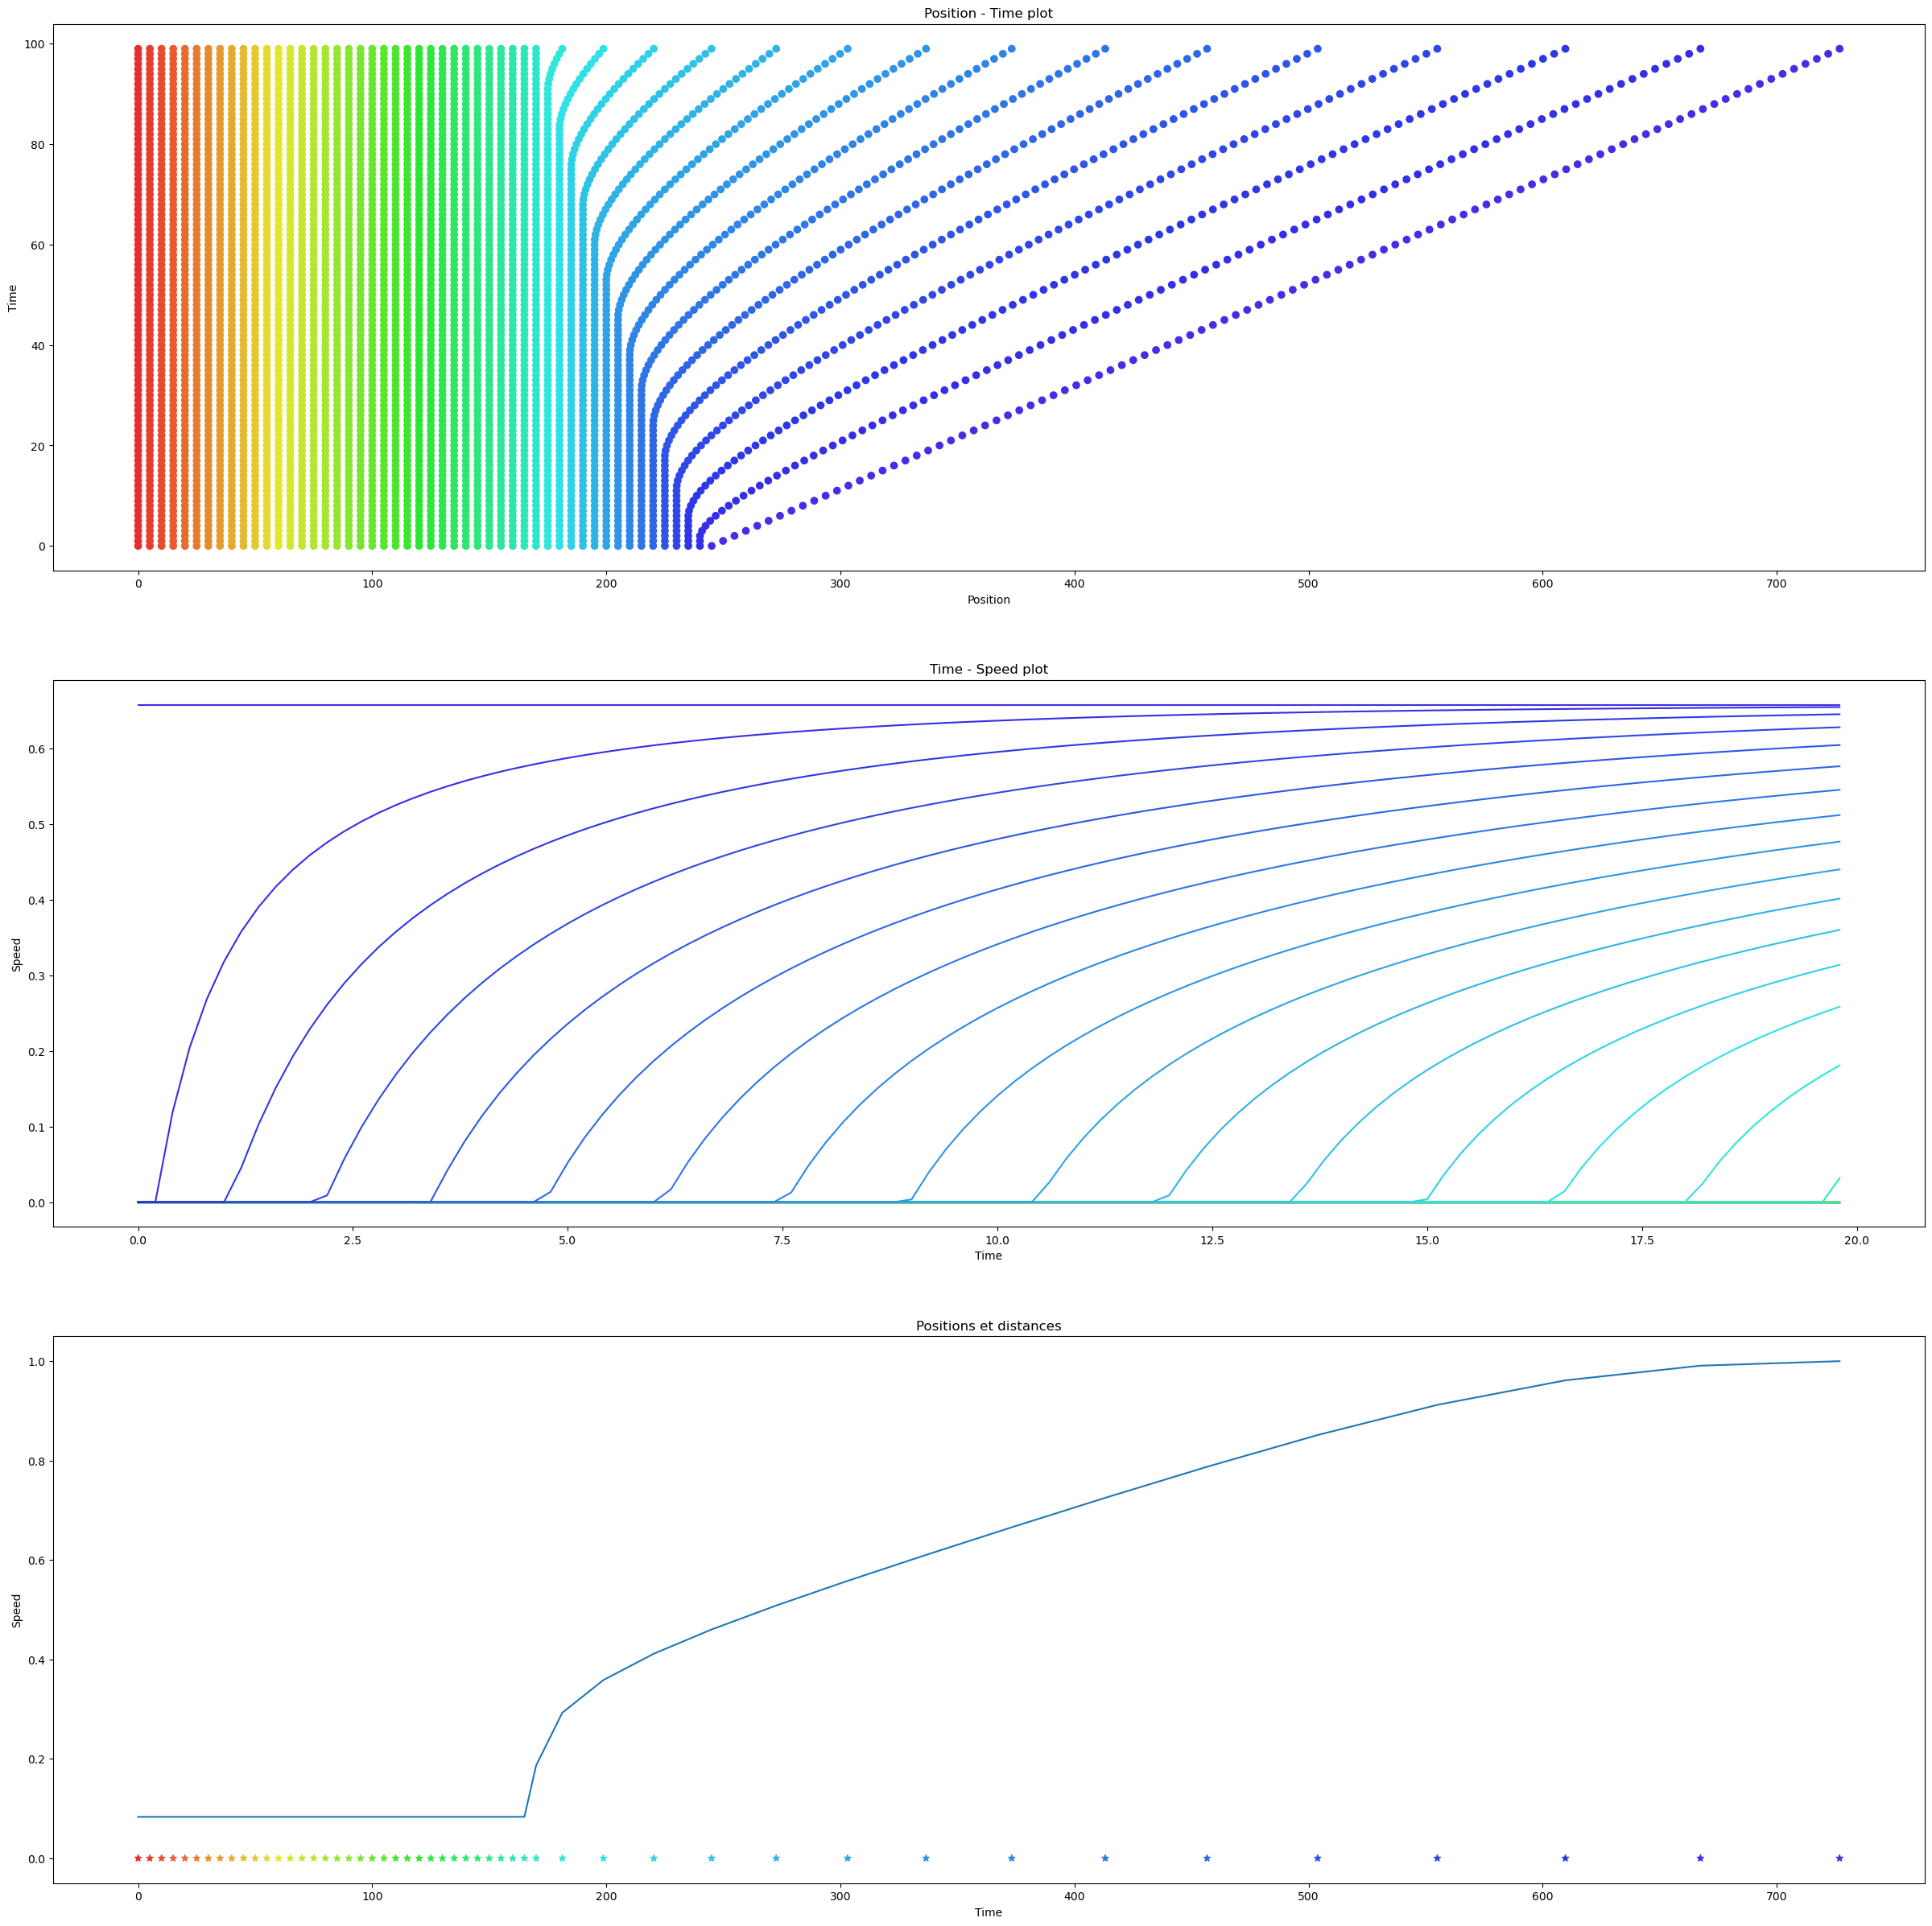

In [7]:
fig, axes = plt.subplots(3, 1, figsize=(30, 30))

position_plot(res, axes[0])
speed_plot(res, F, axes[1])
distance_plot(res, axes[2])

### Interactive plot

In [8]:
def interactive_plot(positions, time_step):
    t = time_step * dt
    x_t = positions[time_step]

    plt.figure(figsize=(20, 3))
    plt.plot(x_t, np.zeros_like(x_t), 'go', markersize=6)

    plt.title(f"State t = {t:.1f} s")
    plt.yticks([])
    plt.xlim(0, np.max(positions) + 50) # Fix max
    plt.grid(True, axis='x')
    plt.show()


widgets.interact(interactive_plot, positions=widgets.fixed(res),
                 time_step=widgets.IntSlider(min=0, max=len(res)-1, step=1, value=0));

interactive(children=(IntSlider(value=0, description='time_step', max=99), Output()), _dom_classes=('widget-in…

## Analysis

Wave propagation speed: Theoretical bound and simulation results


--- Simulation Results ---
Empirical Propagation Speed (c): 3.53 m/s
Theoretical limit c_M = 24.33 m/s


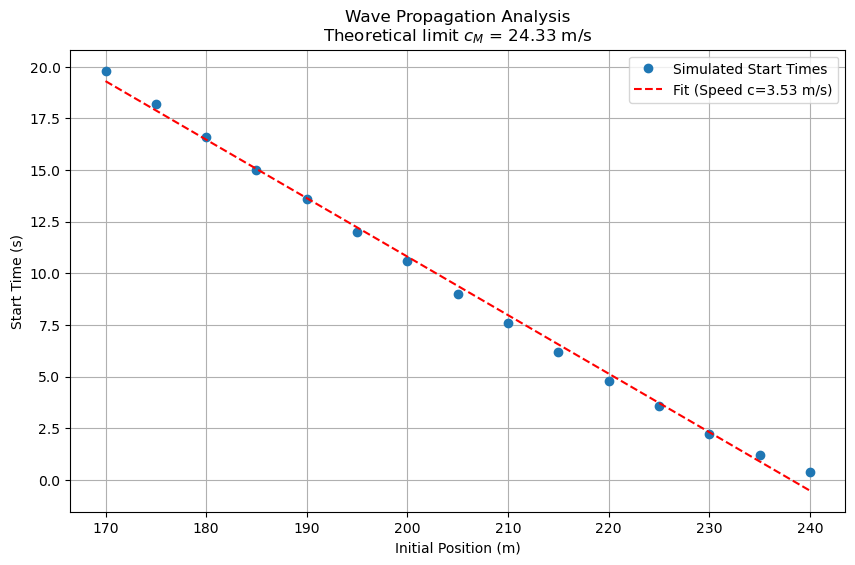

In [9]:
res = simulate() 

V_inf = V_max * F(alpha_inf)

alpha_init = 5.0 
c_M = (alpha_init / (alpha_c - alpha_init)) * V_inf


start_times = np.full(N, -1.0)
start_threshold = 0.1 

for t in range(res.shape[0]):
    
    current_v = vitesse(F, res[t])
    
    just_started = (current_v > start_threshold) & (start_times == -1)
    start_times[just_started] = t * dt


mask = start_times > 0
pos_data = res[0, mask]
time_data = start_times[mask]

slope, intercept = np.polyfit(pos_data, time_data, 1)
c_empirical = 1.0 / abs(slope)

print(f"\n--- Simulation Results ---")
print(f"Empirical Propagation Speed (c): {c_empirical:.2f} m/s")
print(f"Theoretical limit c_M = {c_M:.2f} m/s")


plt.figure(figsize=(10, 6))
plt.plot(pos_data, time_data, 'o', label='Simulated Start Times')
plt.plot(pos_data, slope * pos_data + intercept, 'r--', label=f'Fit (Speed c={c_empirical:.2f} m/s)')

plt.title(f"Wave Propagation Analysis\nTheoretical limit $c_M$ = {c_M:.2f} m/s")
plt.xlabel("Initial Position (m)")
plt.ylabel("Start Time (s)")
plt.legend()
plt.grid(True)
plt.show()